Here, we implement Wasserstein regression using PyTorch. We use PyTorch so that we can utilize the AutoGrad framework to calculate gradients since I do not know a closed-form solution for Wasserstein regression similar to scalar linear regression.

If this does not work since some of the operations do not let the gradients pass through such as `torch.unique` or `torch.searchsorted`, we will use SPSA to estimate the gradients.

In [304]:
import torch # will use for AutoGrad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
torch.cat([torch.tensor(0).reshape(1), torch.diff(torch.tensor([1,2,3,4,5]))])

tensor([0, 1, 1, 1, 1])

In [380]:
def empirical_quantile_function(samples):
    """
    Returns a function that computes the empirical quantile function for the given 1D samples.

    Args:
        samples (torch.Tensor): A 1D tensor of samples from a distribution. Assumes is sorted.

    Returns:
        function: A function that takes a tensor of quantiles (q) and returns the corresponding quantile values.
    """
    samples_diff = torch.cat([samples[0].reshape(1), torch.diff(samples)])
    def quantile_function(q):
        """
        Computes the empirical quantile for the given quantiles.

        Args:
            q (torch.Tensor): A tensor of quantiles (values between 0 and 1).

        Returns:
            torch.Tensor: The corresponding quantile values.
        """
        # Compute the empirical CDF values
        n = len(samples)
        cdf = torch.arange(1, n + 1, dtype=torch.float32) / n
        # Use broadcasting to calculate the Heaviside contributions
        heaviside_matrix = torch.heaviside(q.unsqueeze(1) - cdf.unsqueeze(0), torch.tensor(0.0))
        # Add a column of ones to the left of the Heaviside matrix
        first_col = torch.ones(heaviside_matrix.shape[0]).reshape(-1, 1)
        heaviside_matrix = torch.cat([first_col, heaviside_matrix], dim=1)
        # Remove the last column of Heaviside_matrix
        heaviside_matrix = heaviside_matrix[:, :-1]
        # Compute quantile values by summing contributions
        quantile_values = (heaviside_matrix @ samples_diff)

        return quantile_values
    return quantile_function

# Example usage
samples = torch.tensor([1.0, 2.0]).requires_grad_(True)
quantile_fn = empirical_quantile_function(samples)
quantiles = torch.tensor([0.1, 0.5, 1.0])
result = quantile_fn(quantiles)
result

tensor([1., 1., 2.], grad_fn=<MvBackward0>)

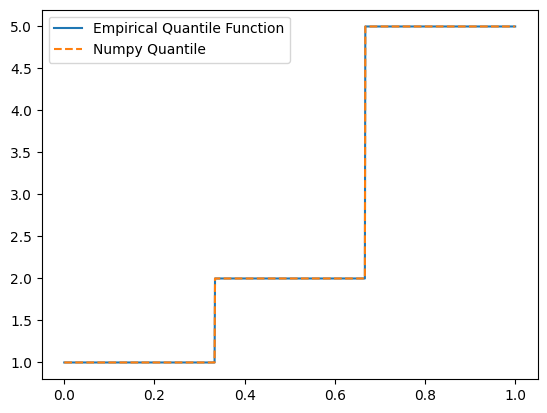

In [410]:
samples = torch.tensor([1.0, 2.0, 5.0])
q_func = empirical_quantile_function(samples)
x = torch.linspace(0,1,1000)

# quantiles_torch = torch.quantile(samples, x, interpolation='midpoint')
quantiles_npy = np.quantile(samples.numpy(), x.numpy(), interpolation='inverted_cdf')
y = q_func(x)

plt.figure()
x_npy = x.numpy()
plt.plot(x_npy, y.detach().numpy())
# plt.plot(x_npy, quantiles_torch.detach().numpy())
plt.plot(x_npy, quantiles_npy, linestyle='--')
plt.legend(['Empirical Quantile Function', 'Numpy Quantile'])

In [411]:
def step_function(x_points, y_points, x):
    # Find the interval that x falls into
    idx = torch.searchsorted(x_points, x, right = True) - 1
    # If x is before the first point, return the first y
    if idx < 0:
        return y_points[0]
    # If x is beyond the last point, return the last y
    elif idx >= len(y_points):
        return y_points[-1]
    # Otherwise, return the y corresponding to the interval
    return y_points[idx]

val = step_function(x,y, 0.5)
val

tensor(2.)

In [57]:
val.backward()

In [426]:
def squared_difference_integral(quantile_func1, quantile_func2, N = 1000):
    quantiles = torch.linspace(0,1,N)
    return torch.sum((quantile_func1(quantiles) - quantile_func2(quantiles)) ** 2) / N

# Example usage
samples1 = torch.tensor([1.0, 2.0]).requires_grad_(True)
samples2 = torch.tensor([2.0, 3.0]).requires_grad_(True)

q1 = empirical_quantile_function(samples1)
q2 = empirical_quantile_function(samples2)

W2 = squared_difference_integral(q1, q2)
W2

tensor(1., grad_fn=<DivBackward0>)

In [466]:
def linear_combination(quantile_fns, weights):
    def lin_comb_fn(q):
        # Compute the quantile values for each function
        quantile_values = torch.stack([fn(q) for fn in quantile_fns])
        # Compute the weighted sum of quantile values
        lin_comb_values = torch.sum(weights.unsqueeze(1) * quantile_values, dim=0)

        return lin_comb_values

    return lin_comb_fn

def barycenter_threshold(quantile_fns, threshold, distances):
    if len(quantile_fns) != len(distances):
        raise ValueError("The number of quantile functions must match the number of distances.")
    quantile_fns = [fn for (fn,dist) in zip(quantile_fns, distances) if dist <= threshold]
    weights = torch.tensor([1/len(quantile_fns)] * len(quantile_fns))
    return linear_combination(quantile_fns, weights)

def barycenter_threshold_soft(quantile_fns, threshold, distances, sharpness=100):
    if len(quantile_fns) != len(distances):
        raise ValueError("The number of quantile functions must match the number of distances.")
    x = torch.sigmoid((threshold - distances) * sharpness)
    weights = x / torch.sum(x)
    return linear_combination(quantile_fns, weights)

# Example usage
samples1 = torch.tensor([1.0, 2.0]).requires_grad_(True)
samples2 = torch.tensor([2.0, 3.0]).requires_grad_(True)
samples3 = torch.tensor([3.0, 4.0]).requires_grad_(True)

q1 = empirical_quantile_function(samples1)
q2 = empirical_quantile_function(samples2)
q3 = empirical_quantile_function(samples3)

quantile_fns = [q1, q2, q3]
weights = torch.tensor([1/3, 1/3, 1/3])
lin_comb_fn = linear_combination(quantile_fns, weights)

quantiles = torch.tensor([0.1, 0.5, 1.0])
print(lin_comb_fn(quantiles))

barycenter_fn = barycenter_threshold(quantile_fns, 1.0, torch.tensor([0.5, 0.9, 1.5]))
print(barycenter_fn(quantiles))

barycenter_fn_soft = barycenter_threshold_soft(quantile_fns, 1.0, torch.tensor([0.5, 0.9, 1.5]), sharpness=100)
print(barycenter_fn_soft(quantiles))

tensor([2., 2., 3.], grad_fn=<SumBackward1>)
tensor([1.5000, 1.5000, 2.5000], grad_fn=<SumBackward1>)
tensor([1.5000, 1.5000, 2.5000], grad_fn=<SumBackward1>)


In [415]:
x = torch.linspace(0, 1, 100)
samples = torch.tensor([1.0, 2.0, 5.0]).requires_grad_(True)
q = torch.quantile(samples, x, interpolation='higher')
q

tensor([1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5.], grad_fn=<SqueezeBackward4>)

In [416]:
def expectation(quantile_func, N = 1000):
    x = torch.linspace(0, 1, N)
    quantiles = quantile_func(x)
    return torch.trapezoid(quantiles, x=x)

samples = torch.tensor([1.0, 2.0, 5.0]).requires_grad_(True)
q_func = empirical_quantile_function(samples)

E = expectation(q_func)
print(E)
print(torch.mean(samples))

tensor(2.6647, grad_fn=<DivBackward1>)
tensor(2.6667, grad_fn=<MeanBackward0>)


In [383]:
E.backward()

We should be ready now to implement the Wasserstein regression for the WRDS dataset.

In [146]:
torch.norm(torch.tensor([1.0,2.0,3.0]), p = 1)

tensor(6.)

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import scipy as sp

In [155]:
with open('quarterly_actual.pkl', 'rb') as f:
    quarterly_actual = pickle.load(f)
    
with open('quarterly_data.pkl', 'rb') as f:
    quarterly_data = pickle.load(f)
    
with open('ibes_tickers.pkl', 'rb') as f:
    ibes_tickers = pickle.load(f)

In [384]:
quarterly_data['AAPL', 2024, 1].head()

,value,ann_datetime
622,2.040,2023-11-02 20:51:00
623,2.084,2023-11-02 22:00:00
624,2.120,2023-11-02 23:10:00
625,2.080,2023-11-02 22:54:00
626,2.080,2023-11-02 23:04:00


Let's optimize for AAPL for 1 column: 2024 Q1

In [173]:
import torch.optim as optim

In [418]:
year = 2024
quarter = 1

actual_eps, actual_date, actual_time = quarterly_actual['AAPL', year, quarter]

actual_datetime = pd.to_datetime(actual_date + ' ' + actual_time, format = '%Y-%m-%d %H:%M:%S')

quantile_funcs = list()
weights = list()
tickers_used = list()

for oftic,_ in ibes_tickers:
    data = quarterly_data[oftic, year, quarter]
    if data is None:
        continue
    data = data[data['ann_datetime'] < actual_datetime]
    if len(data) == 0:
        continue
    quantile_funcs.append(empirical_quantile_function(torch.tensor(data['value'].sort_values().values).float()))
    tickers_used.append(oftic)
    
weights = torch.tensor([1/len(quantile_funcs) for _ in quantile_funcs], requires_grad = True)

# Optimize weights
optimizer = optim.Adam([weights], lr = 0.01)

In [419]:
l1_hyper = 0.01
for i in tqdm(range(500)):
    optimizer.zero_grad()
    barycenter_fn = linear_combination(quantile_funcs, weights)
    mean = expectation(barycenter_fn)
    loss = (mean - actual_eps) ** 2 + (l1_hyper * torch.norm(weights, p = 1))
    loss.backward()
    optimizer.step()

100%|██████████| 500/500 [00:12<00:00, 41.23it/s]


For estimation using multiple columns, we will need to check for missing data in each column and remove any rows with missing data across all columns to ensure that the weights make sense.

In [281]:
def get_rows_cols():
    cols = [(year, quarter) for year in range(2020, 2025) for quarter in range(1, 5)]
    rows = [t[0] for t in ibes_tickers]
    return rows, cols

rows, cols = get_rows_cols()

In [283]:
train_cols = cols[:len(cols) // 2]
test_col = cols[len(cols) // 2]

In [420]:
with torch.no_grad():
    barycenter_fn = linear_combination(quantile_funcs, weights)
    mean = expectation(barycenter_fn)
    print(mean, actual_eps)

tensor(2.1792) 2.18


<BarContainer object of 494 artists>

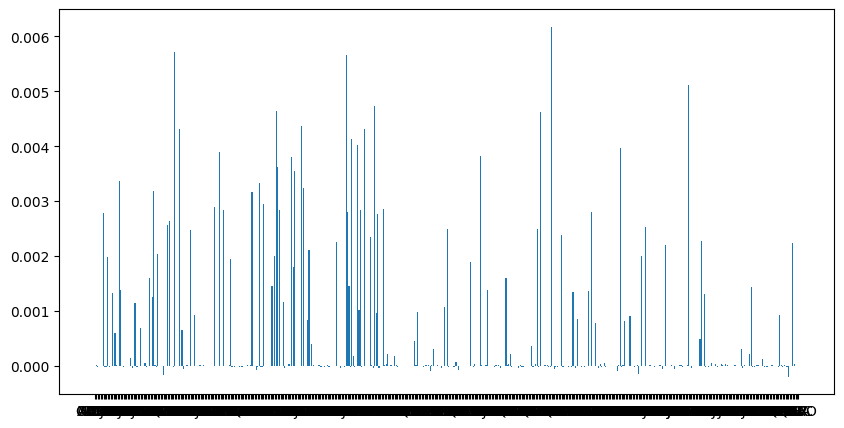

In [421]:
plt.figure(figsize = (10,5))
plt.bar(tickers_used, weights.detach().numpy())

In [422]:
large_inds = np.where(np.abs(weights.detach().numpy()) > 0.005)[0]

In [423]:
np.array(tickers_used)[large_inds]

array(['BKNG', 'AZO', 'NVR', 'EG'], dtype='<U5')

In [424]:
quantile_funcs2 = list()

actual_eps, actual_date, actual_time = quarterly_actual['AAPL', year, 2]
actual_datetime = pd.to_datetime(actual_date + ' ' + actual_time, format = '%Y-%m-%d %H:%M:%S')

for oftic in tickers_used:
    data = quarterly_data[oftic, year, 2]
    data = data[data['ann_datetime'] < actual_datetime]
    if data.shape[0] == 0:
        print(oftic)
        continue
    quantile_funcs2.append(empirical_quantile_function(torch.tensor(data['value'].sort_values().values).float()))

In [425]:
barycenter_fn = linear_combination(quantile_funcs2, weights)
mean = expectation(barycenter_fn)

print(mean, quarterly_actual['AAPL', year, 2][0])

tensor(2.0147, grad_fn=<DivBackward1>) 1.53


tensor(1.9390, grad_fn=<PowBackward0>)

We can use this code to replace the hyperparameter tuning stuff in the previous notebooks. We can use differntiable thresholding to achieve this: `torch.Sigmoid` is a good choice for this.